# Inteligencia Artificial
# Clase 8 - Redes Neuronales con Keras

Los ejemplos que vimos hasta el momento pusieron el foco en los problemas de clasificación. En esta notebook, vamos a utilizar redes neuronales para resolver un ejercicio de regresión.

El dataset con el que trabajaremos es el famoso dataset de Boston, publicado originalmente en el año 1978 por Harrison y Rubinfeld en el paper [Hedonic prices and the demand for clean air](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.926.5532&rep=rep1&type=pdf). Estos datos forman parte de los ejemplos ilustrativos de Keras.

El código de esta notebook se basa mayormente en un ejemplo del [capítulo 3 del libro Deep Learning with Python](https://livebook.manning.com/book/deep-learning-with-python/chapter-3/), escrito por François Chollet, el creador de Keras.

## Prediciendo el precio de casas: un ejemplo de regresión

Los problemas de regresión consisten en predecir un valor continuo, en oposición a los problemas de clasificación que predicen una variable discreta.
Por ejemplo, predecir la temperatura mañana, dada la información meteorológica, o predecir el tiempo que va a llevar terminar un proyecto de *software*, dadas sus especificaciones.
No confundir "regresión" con el algoritmo de "regresión logística": confusamente, la "regresión logística" no es un algoritmo de regresión, es un algoritmo de clasificación.

## El dataset The Boston Housing Price


Vamos a intentar predecir el precio mediano de las viviendas en un suburbio particular de Boston a mediados de los años 70's, dado unos pocos datos sobre el suburbio en esa época, como la tasa de criminalidad, la tasa del impuesto local a la propiedad, etc.

El dataset que vamos a estar usando tiene otra diferencia interesante con respecto a otros de los ejemplos previos: tiene muy pocos datos, sólo 506, divididos en 404 para training y 102 para test, y cada atributo (o *feature*) tiene una escala diferente. 
Por ejemplo, algunos valores son proporciones, que toman valor entre 0 y 1, mientras que otros toman valores en 1 y 12, otros entre 0 y 100...

Veamos el dataset:

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

Using TensorFlow backend.


In [2]:
# Revisamos shape de train_data y test_data
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

Como podemos ver, hay 404 datos de train y 102 de test. La información comprende 13 atributos. Los 13 atributos son los siguientes:

1. Tasa de criminalidad per cápita.
2. Proporción de tierra zonificada como residencial por lote sobre 25.000 pies cuadrados.
3. Proporción de acres de negocios que no son *retail* por pueblo.
4. Variable *dummy*: toma valor uno en las orillas del río Charles.
5. Concentración de óxido nitroso (partes por 10 millones).
6. Número de cuartos promedio por vivienda.
7. Proporción de unidades ocupadas por el dueño construidas antes de 1940.
8. Distancias ponderadas a 5 centros de empleo de Boston.
9. Índice de accesibilidad a autopistas radiales.
10. Tasa del impuesto a la propiedad del valor completo por cada $10,000.
11. Ratio de maestros pupilo por pueblo.
12. 1000 * (Bk - 0.63) ** 2 donde Bk es la proporción de negros en el pueblo. (_sic_)
13. Porcentaje de la población de más bajo status. (_sic_)

El target es el valor mediano de casa ocupadas por sus dueños, en miles de dólares:

In [4]:
# Revisamos train_targets
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

Los precios son típicamente entre 
\$10,000 y \$50,000. Si parece barato, recordemos que son precios de mediados de la década de 1970 y que no son precios ajustados por inflación.

## Preparando los datos


**Sería problemático alimentar una red neuronal con valores que todos toman rangos tan diferentes**. La red tal vez sea capaz de automáticamente adaptar datos tan heterogéneos pero definitivamente esto va a hacer que el aprendizaje sea más dificultoso. Una buena práctica ampliamente difundida para lidiar con este tipo de datos es **normalizar por atributo**: para cada atributo de los datos de entrada (una columna en la matriz *input* de datos), **vamos a sustraer la media del atributo y dividir por su desvío estándar, para que así el atributo esté centrado en 0 y tenga desvío estándar unitario**. Esto es fácilmente realizable en Numpy:

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Nótese que las cantidad que usamos para normalizar el set de test han sido computadas usando la información de train. Nunca debemos usar en nuestro flujo de trabajo cantidades computadas en el set de test, incluso para algo tan simple como la normalización de datos.

## Construyendo nuestra red

Debido a que tan pocas muestras están disponibles, vamos a usar una red muy chica con dos capas ocultas, cada una con 64 unidades. En general, cuanto menos set de train tengamos, mayor va a ser el *overfitting*, y usar una red chica es una forma de mitigarlo. Vamos a definir una función que nos permita construir y compilar nuestra red:

In [0]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Nuestra red termina en **una sola unidad y sin activación** (es decir, va a ser una capa lineal). Ésta es una disposición típica para **regresiones escalares** (donde estamos intentando predecir un único valor continuo). 
Aplicar una función de activación impondría una restricción al rango que el *output* puede tomar; por ejemplo, si aplicáramos una función de activación sigmoidea a nuestra última capa, la red podría sólo aprender a predecir valores entre 0 y 1. Acá, debido a que la última capa es puramente lineal, la red es libre de aprender a predecir valores en cualquier rango.

Nótese que estamos construyendo la red con la **función de pérdida `mse`** -- Mean Squared Error (error cuadrático medio, el cuadrado de la diferencia entre las predicciones y el objetivo, una función de pérdida ampliamente utilizada en problemas de regresión).

También estamos monitoreando una nueva **métrica durante el entrenamiento: `mae`**. Se refiere a las siglas en inglés Mean Absolute Error. Es simplemente el valor absoluto de la diferencia entre las predicciones y el objetivo. Por ejemplo, un MAE de 0.5 en este problema significaría que nuestras predicciones están erradas por $500 en promedio.

## Validando nuestro enfoque usando k-fold CV


Para evaluar nuestra red mientras ajustamos los hiperparámetros (como el número de *epochs* usados para entrenar), vamos simplemente a hacer un *split* de nuestros datos en un set de entrenamiento y un set de validación. Sin embargo, debido a que tenemos muy pocos datos, el set de validación va a terminar siendo demasiado chico (aproximadamente 100 casos).

Como consecuencia, nuestros *scores* de validación pueden cambiar demasiado dependiendo qué observaciones elijamos para validar y cuáles para entrenar, es decir, **los *scores* de validación pueden tener una alta varianza según qué *split* de validación se haga**. Esto nos impediría evaluar de manera fiable nuestro modelo.

**La mejor práctica en estas situaciones es usar *k-fold cross-validation***. Consiste en hacer un *split* de la información disponible en K particiones (típicamente K = 4 o K = 5), luego instanciar K modelos idénticos, y entrenar cada uno en K-1 particiones mientras se evalúan en la partición restante. El *score* de validación del modelo es entonces el promedio de los K *scores* de validación obtenidos.

En términos de código, esto es directo:

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('Procesando fold #', i+1)
    # Prepara el set de validación: datos de la partición k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepara el set de training: datos de todas las particiones
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construye el modelo de Keras (ya compilado)
    model = build_model()
    
    # Entrena el modelo (en modo silencioso, verbose = 0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evalúa el modelo en los datos de validación
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    # Guardamos el MAE en la lista all_scores
    all_scores.append(val_mae)

Procesando fold # 1
Procesando fold # 2
Procesando fold # 3
Procesando fold # 4


In [8]:
# Revisamos los valores guardados en all_scores
all_scores

[1.7703580856323242,
 2.7516608238220215,
 2.4214231967926025,
 2.8638968467712402]

In [9]:
# Calculamos la media con np.mean
np.mean(all_scores)

2.451834738254547

Como podemos notar, las diferentes corridas muestran *scores* más bien diferentes, desde 2.1 a 2.9. Su promedio (2.4) es una métrica mucho más confiable que cualquier de esos valores individuales -- este es el punto de *k-fold cross-validation*. En este caso, en promedio erramos por \$2,400, lo cual es aún significativo, considerando que el rango de precios va de \$10,000 a \$50,000.

Intentemos entrenar una red por un poco más de tiempo: 500 epochs. Para mantener un registro de qué tan bien el modelo anduvo en cada *epoch*, vamos a modificar nuestro *loop* de entrenamiento para guardar el log del *score* de validación por *epoch*:

In [0]:
from keras import backend as K

# Memory clean-up
K.clear_session()

In [11]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Procesando fold #', i+1)
    # Prepara el set de validación: datos de la partición k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepara el set de training: datos de todas las particiones
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construye el modelo de Keras (ya compilado)
    model = build_model()

    # Entrena el modelo (en modo silencioso, verbose = 0)
    # Ahora, asignamos el retorno de fit() a la variable history
    history = model.fit(partial_train_data, partial_train_targets,
                        # Podemos especificar un set de validación
                        # especifico usando validation_data
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    # El atributo `history` de un objeto tipo `History`
    # contiene un diccionario con las métricas monitoreadas en cada epoch
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Procesando fold # 1
Procesando fold # 2
Procesando fold # 3
Procesando fold # 4


Luego podemos computar el promedio del MAE *score*  por *epoch* para todas las particiones:

In [0]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Grafiquemos esto:

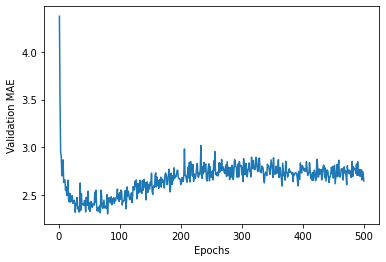

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Puede ser un poco difícil ver el gráfico debido a problemas de escalas y relativamente alta varianza. Hagamos lo siguiente:

* Omitamos los primeros 10 puntos de datos, que están en una  escala diferente del resto de la curva.
* Reemplacemos cada punto con un promedio móvil exponencial de los puntos previos, para obtener una curva suave.

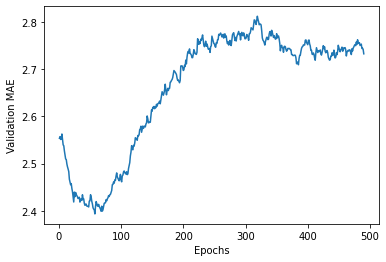

In [14]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

De acuerdo con este gráfico, parece que el MAE de validación deja de mejorar significativamente después de 80 *epochs*. Pasado este punto, empieza a overfittear.

Una vez que terminamos de ajustar los parámetros de nuestro modelo (además del número de *epochs*, podemos ajustar el tamaño de las capas ocultas), podemos entrenar un modelo final para poner en producción, sobre toda nuestra información de train, con los mejores parámetros, y después ver la *performance* en test:

In [15]:
# Armar modelo
model = build_model()

# Entrenamos el modelo con el training set completo. Esta vez elegimos un
# batch size de 16 y tomamos el número de epochs con mejor MAE en validación.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

In [16]:
# Imprimimos el MAE obtenido esta vez.
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 170us/step


2.814987897872925

Todavía tenemos un error de alrededor de \$2,550.

## Utilizando `cross_val_score()` de Scikit - Learn con Keras

Recién hicimos la validación cruzada definiendo los *folds* con indexaciones variables de la matriz de entrada e iterando sobre ellos con un *for loop*. ¿Por qué hacerlo de esta manera cuando podríamos aprovechar la función `cross_val_score()` provista por Scikit - Learn? Veamos qué ocurre cuando intentamos hacer *cross - validation* de la forma a la que estamos acostumbrados cuando trabajamos con esta otra biblioteca:

In [17]:
from sklearn.model_selection import cross_val_score
model = build_model(input_shape=(train_data.shape[1],))
cross_val_score(model, train_data, train_targets, cv=4, scoring='neg_mean_absolute_error')

TypeError: ignored

¡Como nuestro modelo no es un estimador propio de Scikit - Learn, no puede ser utilizado como argumento del método `cross_val_score()`!

¿Esto significa que no podemos utilizarlo? ¡Para nada! Por suerte, contamos con un [*wrapper* de Scikit - Learn implementado por Keras](https://keras.io/scikit-learn-api/#wrappers-for-the-scikit-learn-api), que nos permite integrar modelos secuenciales en un *workflow* típico de Scikit - Learn. Existen dos *wrappers* disponibles, `KerasClassifier` y `KerasRegressor`, que nos permiten crear redes neuronales con Keras en un formato apto para ser utilizadas por las utilidades de Scikit - Learn.

In [0]:
# Importamos la clase KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor

Para poder crear una instancia de modelo, estos *wrappers* requieren de una función que se encargue de construir y compilar una red neuronal, tal como nuestra función `build_model()`. Esta función debe especificarse en el argumento `build_fn`. Cualquier argumento propio de la función de construcción también deberán ser aclarados al momento de instanciar el modelo, así como otros *fitting parameters* tales como la cantidad de *epochs*, el tamaño del *batch* o el nivel de verbosidad.

In [0]:
# Instanciamos un modelo a partir de una función de construcción
model = KerasRegressor(build_fn=build_model,
                       epochs=500, batch_size=1, verbose=0)

In [20]:
# Hecho esto, ya podemos utilizar la función cross_val_score() de Scikit - Learn
cross_val_score(model, train_data, train_targets, cv=4, scoring='neg_mean_absolute_error')

array([-2.21688913, -3.26818058, -2.84842151, -2.94367957])

## Resumiendo


Esto es lo que tenemos que llevarnos de esta notebook:

* La regresión se hace usando distintas funciones de pérdida que los problemas de clasificación: el Error Cuadrático Medio (*Mean Squared Error* o MSE) es una función de pérdida comúnmente usada para regresión.
* De manera similar, las métricas de evaluación que se usan para regresión difieren de las de clasificación; el concepto de "accuracy" no aplica en regresión. Una métrica común es el Error Absoluto Medio (*Mean Absolute Error* o MAE).
* Cuando los atributos de la información de *input* tiene valores en diferentes rangos, cada atributo debe ser escalado independientemente como un paso de preprocesamiento.
* Cuando hay poca información disponible, usar K-Fold CV es una excelente manera para evaluar un modelo de manera confiable.
* Cuando hay poca información para entrenar es preferible usar una red pequeña con muy pocas capas ocultas (típicamente sólo una o dos) para evitar el *overfitting*.
* Podemos integrar una red neuronal desarrollada en Keras con las utilidades propias de Scikit - Learn a partir de los *wrappers* `KerasClassifier` y `KerasRegressor`.